# Pondering the Problem of Fitting a Model

## Dividing between training, test and validation

In [1]:
from sklearn.datasets import load_boston
boston = load_boston()
X, y = boston.data, boston.target
print(X.shape, y.shape)

(506, 13) (506,)


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
regression = LinearRegression()
regression.fit(X,y)
print('Mean squared error: %.2f' % mean_squared_error(
    y_true=y, y_pred=regression.predict(X)))

Mean squared error: 21.90


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=5)
print(X_train.shape, X_test.shape)

(354, 13) (152, 13)


In [4]:
regression.fit(X_train,y_train)
print('Train mean squared error: %.2f' % mean_squared_error(
    y_true=y_train, y_pred=regression.predict(X_train)))

Train mean squared error: 19.07


In [5]:
print('Test mean squared error: %.2f' % mean_squared_error(
    y_true=y_test, y_pred=regression.predict(X_test)))

Test mean squared error: 30.70


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=6)
regression.fit(X_train,y_train)
print('Train mean squared error: %.2f' % mean_squared_error(
    y_true=y_train, y_pred=regression.predict(X_train)))
print('Test mean squared error: %.2f' % mean_squared_error(
    y_true=y_test, y_pred=regression.predict(X_test)))

Train mean squared error: 19.48
Test mean squared error: 28.33


# Cross-validating

## Using cross-validation on k folds

In [7]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(regression, X, y, 
    scoring='neg_mean_squared_error', cv=crossvalidation, n_jobs=1)
print('Folds: %i, mean squared error: %.2f std: %.2f' % 
      (len(scores),np.mean(np.abs(scores)),np.std(scores)))

Folds: 10, mean squared error: 23.76 std: 12.13


## Sampling stratifications for complex data

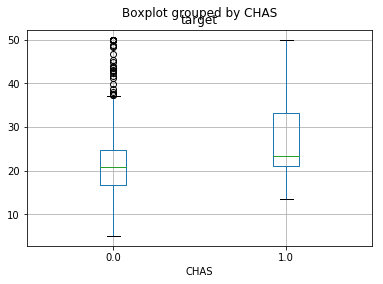

In [8]:
%matplotlib inline
import pandas as pd
df = pd.DataFrame(X, columns=boston.feature_names)
df['target'] = y
df.boxplot('target', by='CHAS', return_type='axes');

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
strata = StratifiedShuffleSplit(n_splits=3, 
                                test_size=0.35, 
                                random_state=0)
scores = list()
for train_index, test_index in strata.split(X, X[:,3]):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regression.fit(X_train, y_train)
    scores.append(mean_squared_error(y_true=y_test, 
                       y_pred=regression.predict(X_test)))
print('%i folds cv mean squared error: %.2f std: %.2f' % 
      (len(scores),np.mean(np.abs(scores)),np.std(scores)))

3 folds cv mean squared error: 24.30 std: 3.99


# Selecting Variables Like a Pro

## Selecting on univariate measures

In [10]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
Selector_f = SelectPercentile(f_regression, percentile=25)
Selector_f.fit(X, y)
for n,s in zip(boston.feature_names,Selector_f.scores_):
    print('F-score: %3.2f\t for feature %s ' % (s,n))

F-score: 88.15	 for feature CRIM 
F-score: 75.26	 for feature ZN 
F-score: 153.95	 for feature INDUS 
F-score: 15.97	 for feature CHAS 
F-score: 112.59	 for feature NOX 
F-score: 471.85	 for feature RM 
F-score: 83.48	 for feature AGE 
F-score: 33.58	 for feature DIS 
F-score: 85.91	 for feature RAD 
F-score: 141.76	 for feature TAX 
F-score: 175.11	 for feature PTRATIO 
F-score: 63.05	 for feature B 
F-score: 601.62	 for feature LSTAT 


## Using a greedy search

In [11]:
from sklearn.feature_selection import RFECV
selector = RFECV(estimator=regression, 
                 cv=10, 
                 scoring='neg_mean_squared_error')
selector.fit(X, y)
print("Optimal number of features : %d" 
      % selector.n_features_)

Optimal number of features : 6


In [12]:
print(boston.feature_names[selector.support_])

['CHAS' 'NOX' 'RM' 'DIS' 'PTRATIO' 'LSTAT']


# Pumping up your hyper-parameters

In [13]:
import numpy as np
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

## Implementing a grid search

In [14]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, 
      weights='uniform', metric= 'minkowski', p=2)

In [15]:
grid = {'n_neighbors': range(1,11), 
        'weights': ['uniform', 'distance'], 'p': [1,2]}
print ('Number of tested models: %i' 
       % np.prod([len(grid[element]) for element in grid]))
score_metric = 'accuracy'

Number of tested models: 40


In [16]:
from sklearn.model_selection import cross_val_score
print('Baseline with default parameters: %.3f' 
      % np.mean(cross_val_score(classifier, X, y, 
                cv=10, scoring=score_metric, n_jobs=1)))

Baseline with default parameters: 0.967


In [17]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(estimator=classifier, 
                      param_grid=grid, 
                      scoring=score_metric, 
                      n_jobs=1, 
                      refit=True, 
                      return_train_score=True, 
                      cv=10)
search.fit(X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [18]:
print('Best parameters: %s' % search.best_params_)
print('CV Accuracy of best parameters: %.3f' % 
      search.best_score_)

Best parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
CV Accuracy of best parameters: 0.973


In [19]:
print(search.cv_results_)

{'mean_fit_time': array([0.00050011, 0.00040007, 0.00030005, 0.00030007, 0.00040007,
       0.00010002, 0.00040009, 0.        , 0.00040009, 0.00050011,
       0.00020006, 0.00060015, 0.00030005, 0.0006001 , 0.00020003,
       0.00090017, 0.00020003, 0.00010002, 0.        , 0.        ,
       0.00010002, 0.00100021, 0.00040009, 0.00060012, 0.00040011,
       0.00020003, 0.00010002, 0.00040009, 0.00050011, 0.00080016,
       0.00030005, 0.00040009, 0.00010002, 0.00020003, 0.00060012,
       0.00010002, 0.        , 0.00050008, 0.00040009, 0.00050008]), 'std_fit_time': array([5.00106816e-04, 4.89979242e-04, 4.58333612e-04, 4.58370036e-04,
       4.89979242e-04, 3.00049782e-04, 4.90008446e-04, 0.00000000e+00,
       4.90008446e-04, 5.00106816e-04, 4.00114063e-04, 4.90018183e-04,
       4.58333612e-04, 4.89979242e-04, 4.00066376e-04, 3.00057738e-04,
       4.00066376e-04, 3.00049782e-04, 0.00000000e+00, 0.00000000e+00,
       3.00049782e-04, 9.53674316e-08, 4.90008446e-04, 4.89998714e-04,
  

In [20]:
from sklearn.model_selection import validation_curve
model = KNeighborsClassifier(weights='uniform', 
                             metric= 'minkowski', p=1)
train, test = validation_curve(model, X, y, 
                               param_name='n_neighbors', 
                               param_range=range(1, 11), 
                               cv=10, scoring='accuracy', 
                               n_jobs=1)

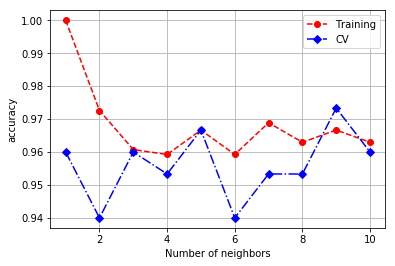

In [21]:
import matplotlib.pyplot as plt
mean_train  = np.mean(train,axis=1)
mean_test   = np.mean(test,axis=1)
plt.plot(range(1,11), mean_train,'ro--', label='Training')
plt.plot(range(1,11), mean_test,'bD-.', label='CV')
plt.grid()
plt.xlabel('Number of neighbors')
plt.ylabel('accuracy')
plt.legend(loc='upper right', numpoints= 1)
plt.show()


## Trying a randomized search

In [22]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=classifier, 
                    param_distributions=grid, n_iter=10, 
    scoring=score_metric, n_jobs=1, refit=True, cv=10, )
random_search.fit(X, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'p': [1, 2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [23]:
print('Best parameters: %s' % random_search.best_params_)
print('CV Accuracy of best parameters: %.3f' % 
      random_search.best_score_)

Best parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 5}
CV Accuracy of best parameters: 0.967
